In [179]:
#Above version is unstable. Changing equations:

using LinearAlgebra, SparseArrays, Plots

# -----------------------
# Parameters & grid
dr = 0.025
rlength = 5
Nr = Int(round(rlength/dr))
r = collect(range(dr/2, stop = rlength - dr/2, length = Nr))

dX = 0.1
xlen = 20.0
Nx = Int(round(xlen/dX))
x = collect(range(0.0, stop = xlen, length = Nx))

Cmu = 0.0035
C1eps = 0.163
C2eps = 2.86
Sigmak = 1.0
Sigmaeps = 1.3

nu = 1.47e-5
k_inf = 1e-3
eps_floor = 1e-10
k_floor = 1e-12

# optional under-relaxation for nu_t
alpha_nu = 0.7

# -----------------------
# Initial fields
U = zeros(Nr, Nx)
V = zeros(Nr, Nx)
k = zeros(Nr, Nx)
eps = zeros(Nr, Nx)

# initial guess for U
U0 = 0.5 .+ 0.25 .* (1 .+ tanh.((r .- 1.2)./0.05))
U[:,1] .= U0
V[:,1] .= 0.0

drU0 = 5.0 .* (sech.((r .- 1.2)./0.05)).^2
a = ((0.125^2)*(2/3) - 1e-3) / maximum(drU0)
k[:,1] .= a .* drU0.^2 .+ k_inf
eps[:,1] .= sqrt(C1eps) .* drU0 .* k[:,1]

nu_t = Cmu .* (k[:,1].^2) ./ (eps[:,1] .+ eps_floor)

# -----------------------
# Derivative matrices
function diff_matrices(N, dr)
    D1 = spzeros(N,N)
    for i in 2:N-1
        D1[i, i-1] = -0.5/dr
        D1[i, i+1] =  0.5/dr
    end
    D1[1,1] = -1.0/dr; D1[1,2] = 1.0/dr
    D1[N,N-1] = -1.0/dr; D1[N,N] = 1.0/dr

    D2 = spzeros(N,N)
    for i in 2:N-1
        D2[i, i-1] = 1.0/dr^2
        D2[i, i]   = -2.0/dr^2
        D2[i, i+1] = 1.0/dr^2
    end

    return Matrix(D1), Matrix(D2)
end

Dr, Drr = diff_matrices(Nr, dr)
rmat = Diagonal(r)
oneonr_mat = Diagonal(1.0 ./ r)


# U-V block (linear)
function form_blocks(Uj, Vj,kj, epsj, dx, rvec, Nr, nu_t_vec, nu)
    #define parameters
    Cmu = 0.0035
    C1eps = 0.163
    C2eps = 2.86
    Sigmak = 1.0
    Sigmaeps = 1.3
    #create nu_t vec which works with input of either field or scalar nu_t
    nu_t_vec = length(nu_t_vec) == 1 ? fill(nu_t_vec, Nr) : nu_t_vec
    nueff = nu .+ nu_t_vec
    nueff_k = nu .+ nu_t_vec/Sigmak
    nueff_eps = nu .+ nu_t_vec/Sigmaeps

    #define some NCCs
    rmat = Diagonal(rvec)
    oneonr = Diagonal(1.0 ./ rvec)
    oneonr[1,1] = 0.0
    nueff_diag = Diagonal(nueff)
    Udiag = Diagonal(Uj)
    Vdiag = Diagonal(Vj)
    kdiag = Diagonal(kj)
    epsdiag = Diagonal(epsj)
    Dr, Drr = diff_matrices(Nr,dr)
    
    #preallocate matrices
    B = zeros(4*Nr, 4*Nr)
    C = zeros(4*Nr)

    #indices of columns -- give which Nccs we are talking about
    nccs_U = 1:Nr
    nccs_V = Nr + 1: 2*Nr
    nccs_k = 2*Nr +1:3*Nr
    nccs_epsilon = 3*Nr + 1:4*Nr

    #indices of rows -- give which equation we are talking about and which RHS terms simultaneously
    eq_cont = 1:Nr
    eq_axial = Nr + 1:2*Nr
    eq_k = 2*Nr + 1: 3*Nr
    eq_epsilon = 3*Nr + 1:4*Nr
    
    
    #Equation 1: Continuity
    B[eq_cont,nccs_U] = Matrix(I,Nr,Nr)
    B[eq_cont,nccs_V] .= (dx)*(oneonr .+ Dr)
    B[eq_cont,nccs_k] .= 0.0
    B[eq_cont,nccs_epsilon] .= 0.0
    C[eq_cont] .= Uj
    
    
    ###
    #Boundary conditions on continuity -> only one derivative taken, V only needs dirichlet condition at r=0
    ###
    
    B[eq_cont[1],:] .= 0.0; B[eq_cont[1],nccs_V[1]] = 1.0; C[eq_cont[1]] = 0.0 #delete entire first row, replace with eq. V at r = 0  = 0

    #Equation 2: Axial momentum
    B[eq_axial,nccs_U] .= Udiag .- (dx/2)*(oneonr*Dr*(rmat.*nueff)*Dr) .+ (dx)*(Vdiag*Dr)
    B[eq_axial,nccs_V] .= 0.0
    B[eq_axial,nccs_k] .= 0.0
    B[eq_axial, nccs_epsilon] .= 0.0
    C[eq_axial] .= (dx/2)*(oneonr*Dr*((rmat.*nueff)*Dr*Uj)) + Uj.^2
    
    ###
    #Boundary conditions on axial momentum -> neummann on U at r=0 and dirichlet at edge
    ###

    B[eq_axial[1],:] .= 0.0; B[eq_axial[1],nccs_U] .= Dr[1,:]; C[eq_axial[1]] = 0.0 #replace first line of axial equation acting on U w/ dmat
    B[eq_axial[end],:] .= 0.0; B[eq_axial[end],nccs_U[end]] = 1.0; C[eq_axial[end]] = 1.0 #end of axial equation replace row with dirichlet condition at the end of U

    #Equation 3: k evolution
    B[eq_k,nccs_U] .= 0.0
    B[eq_k,nccs_V] .= 0.0
    B[eq_k,nccs_k] .= Udiag .+ dx*Vdiag*Dr .- (dx/2)*(oneonr*Dr*(rmat.*nueff_k)*Dr)
    B[eq_k,nccs_epsilon] .= 0.0
    C[eq_k] .= dx*nu_t_vec.*(Dr*Uj).^2 .- dx*epsj .+ (dx/2)*(oneonr*Dr*(rmat.*nueff_k)*Dr*kj) .+ Udiag*kj

    ###
    #Boundary conditions on k evolution -> neummann on k at r=0 and dirichlet at edge
    ###

    B[eq_k[1],:] .= 0.0; B[eq_k[1],nccs_k] .= Dr[1,:]; C[eq_k[1]] = 0.0
    B[eq_k[end],:] .= 0.0; B[eq_k[end],nccs_k[end]] = 1.0; C[eq_k[end]] = k_inf

    #Equation 4: epsilon evolution
    B[eq_epsilon,nccs_U] .= 0.0
    B[eq_epsilon,nccs_V] .= 0.0
    B[eq_epsilon,nccs_k] .= 0.0
    B[eq_epsilon,nccs_epsilon] .= Udiag .+ dx*Vdiag*Dr - (dx/2)*(oneonr*Dr*(rmat.*nueff_eps)*Dr)
    C[eq_epsilon] .= (dx*C1eps*epsj./kj).*(nu_t_vec.*(Dr*Uj).^2) .- (dx*C2eps.*(epsj.^2)./kj) .+ (dx/2)*(oneonr*Dr*(rmat.*nueff_eps)*Dr*epsj) + Udiag*epsj

    ###
    #Boundary conditions on epsilon evolution -> neummann on epsilon at r=0 and dirichlet at edge
    ###

    B[eq_epsilon[1],:] .= 0.0; B[eq_epsilon[1],nccs_epsilon] .= Dr[1,:]; C[eq_epsilon[1]] = 0.0
    B[eq_epsilon[end],:] .= 0.0; B[eq_epsilon[end],nccs_epsilon[end]] = 1.0; C[eq_epsilon[end]] = 0.0

    
    return B,C
end
B,C = form_blocks(U[:,1], V[:,1], k[:,1], eps[:,1],dX, r, Nr, nu_t, nu)

([0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1619.098151452432 -1082.3489730587096; 0.0 0.0 … 0.0 1.0], [0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  3.095584802355396e-61, 1.138843266089574e-61, 4.189720449154014e-62, 1.5413667040762177e-62, 5.670570329335479e-63, 2.0861587437297065e-63, 7.674813125800575e-64, 2.82350209955159e-64, 9.627560141119949e-65, 0.0])

In [180]:
nu_t_current = nu_t
for j = 1:Nx - 1
    B, C = form_blocks(U[:,j], V[:,j], k[:,j], eps[:,j],dX, r, Nr, nu_t_current, nu)
    # print(j)
    A = B \ C
    U[:,j + 1] .= A[1:Nr]
    V[:, j + 1] .= A[Nr + 1:2*Nr]
    k[:, j + 1] .= A[2*Nr + 1: 3*Nr]
    eps[:, j + 1] .= A[3*Nr + 1:4*Nr]
    nu_t_current = Cmu .* (k[:,j + 1].^2) ./ (eps[:,j + 1] .+ eps_floor)
end

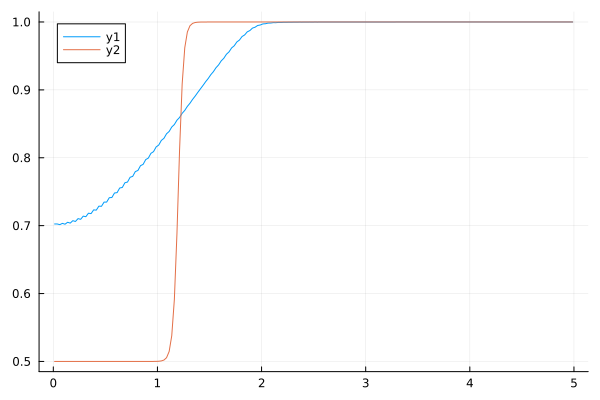

In [183]:
plot(r,U[:,end])
plot!(r,U[:,1])

[ Info: Saved animation to /home/dylan/U_vs_r.gif


Plots.AnimatedGif("/home/dylan/U_vs_r.gif")
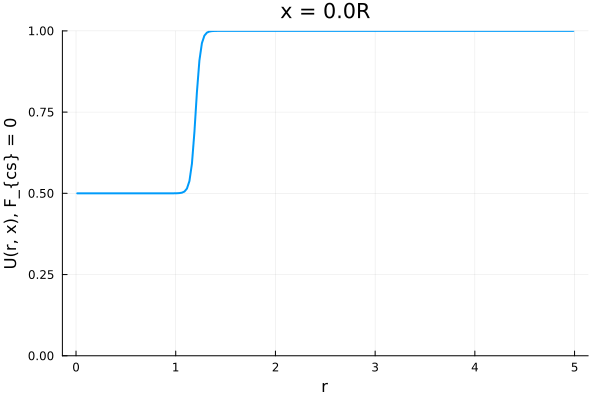

In [187]:
using Plots
gr()  # use GR backend (works well in IJulia)

# Suppose:
# r :: Vector
# x :: Vector
# U :: Matrix, size (length(r), length(x))

# Example structure:
# plot(r, U[:, 1])     # first x
# plot(r, U[:, end])   # last x

anim = @animate for j in 1:length(x)
    plot(r, U[:, j],
        xlabel = "r",
        ylabel = "U(r, x), F_{cs} = 0",
        title = "x = $(round(x[j], digits=3))R",
        ylim = (minimum(U) - .5, maximum(U)),  # fix y-limits
        lw = 2,
        legend = false)
end

gif(anim, "U_vs_r.gif", fps = 15)
